In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from torch.optim import Adam, SGD, RMSprop, Adagrad, Adadelta
from tqdm import tqdm

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('C:/Users/Administrator/Desktop/pipelines/order_data/data2.csv')
df.head(5)

,title,annotations,target
0,ФАКТОР НАСЛЕДСТВЕННОЙ ТРОМБОФИЛИИ У ПАЦИЕНТОК ...,618.145-007.415:575_x000D_\n_x000D_\nФАКТОР НА...,"Научные основы охраны здоровья матери, женщины..."
1,ОПЫТ ИСПОЛЬЗОВАНИЯ МЕТОДИК ТЕРОПЕВТИЧЕСКОЙ РЕК...,ОПЫТ ИСПОЛЬЗОВАНИЯ МЕТОДИК ТЕРОПЕВТИЧЕСКОЙ РЕК...,Трудный диагноз в педиатрии: от практики к науке.
2,Сравнительная характеристика Нр-позитивного и ...,Сравнительная характеристика Нр-позитивного и ...,Возрастные особенности формирования здоровья в...
3,Современные подходы к лечению постравматически...,Современные подходы к лечению постравматически...,Трудный диагноз в клинике внутренних болезней.
4,Современные аспекты диагностики и лечения ВМД,Современные аспекты диагностики и лечения ВМД,"Разработка новых методов профилактики, прогноз..."


In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        205 non-null    object
 1   annotations  205 non-null    object
 2   target       205 non-null    object
dtypes: object(3)
memory usage: 4.9+ KB


In [9]:
unk_labels = [df['target'].value_counts()[df['target'].value_counts() < 5].index[i] for i in range(len(df['target'].value_counts()[df['target'].value_counts() < 5]))]

<AxesSubplot:title={'center':'Count (target)'}>

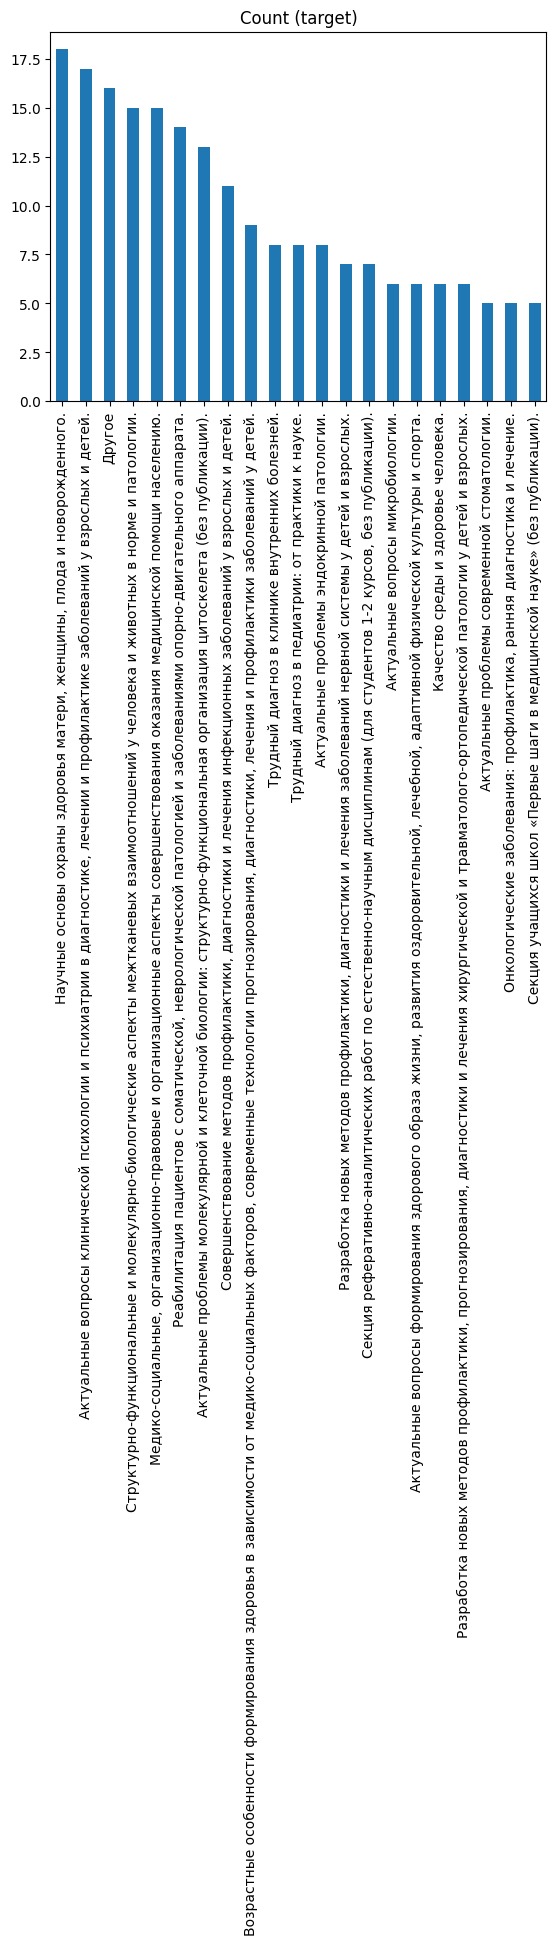

In [10]:
df['target'] = df['target'].apply(lambda x: 'Другое' if x in unk_labels else x)
df['target'].value_counts().plot(kind='bar', title='Count (target)')


In [11]:
df = df.drop('annotations', axis=1)

In [12]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [18]:
import torch
from torch import nn
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from torch.optim import Adam, SGD, RMSprop, Adagrad, Adadelta
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm

In [19]:
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name, truncation=True, do_lower_case=True, return_tensors='pt')

In [20]:
labels = {}
for index, label in enumerate(df['target'].unique()):
    labels[label] = index
labels

{'Научные основы охраны здоровья матери, женщины, плода и новорожденного.': 0,
 'Трудный диагноз в педиатрии: от практики к науке.': 1,
 'Возрастные особенности формирования здоровья в зависимости от медико-социальных факторов, современные технологии прогнозирования, диагностики, лечения и профилактики заболеваний у детей.': 2,
 'Трудный диагноз в клинике внутренних болезней.': 3,
 'Разработка новых методов профилактики, прогнозирования, диагностики и лечения хирургической и травматолого-ортопедической патологии у детей и взрослых.': 4,
 'Разработка новых методов профилактики, диагностики и лечения заболеваний нервной системы у детей и взрослых.': 5,
 'Актуальные вопросы клинической психологии и психиатрии в диагностике, лечении и профилактике заболеваний у взрослых и детей.': 6,
 'Другое': 7,
 'Структурно-функциональные и молекулярно-биологические аспекты межтканевых взаимоотношений у человека и животных в норме и патологии.': 8,
 'Актуальные проблемы молекулярной и клеточной биологии

In [21]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, max_length):
        self.labels = [labels[label] for label in df['target']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = max_length, truncation=True,
                                return_tensors="pt") for text in df['title']]
    def classes(self):
        return self.labels
    def __len__(self):
        return len(self.labels)
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [22]:
np.random.seed(112)
df_train, df_test_val = np.split(df.sample(frac=1, random_state=42),
                                     [int(.7*len(df))])
df_val, df_test = np.split(df_test_val.sample(frac=1, random_state=42),
                                     [int(.5*len(df_test_val))])

print(len(df_train),len(df_val), len(df_test))

143 31 31


In [26]:
state_dict = torch.load('C:/Users/Administrator/Desktop/pipelines/science_data/model1.pt')

In [27]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = RobertaModel.from_pretrained(model_name)
        self.act = nn.ReLU(0.2)
        self.drop = nn.Dropout(0.12)
        self.linear_1 = nn.Linear(self.bert.config.hidden_size*2, 1024)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 6)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask):
        last_hidden_state = self.bert(input_ids=input_id, attention_mask=mask).last_hidden_state
        mean_pooling_embeddings = torch.mean(last_hidden_state, 1)
        _, max_pooling_embeddings = torch.max(last_hidden_state, 1)
        mean_max_embeddings = torch.cat((mean_pooling_embeddings, max_pooling_embeddings), 1)
        logits = self.linear_1(mean_max_embeddings)
        logits = self.drop(self.act(logits))
        logits = self.linear_2(logits)
        logits = self.act(logits)
        logits = self.linear_3(logits)
        final_layer = self.softmax(logits)

        return final_layer

In [28]:
model = BertClassifier()
model.load_state_dict(state_dict)
model

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [29]:
class ModifiedBert(nn.Module):
    def __init__(self):
        super(ModifiedBert, self).__init__()
        self.bert = RobertaModel.from_pretrained(model_name)
        self.act = nn.ReLU(0.2)
        self.drop = nn.Dropout(0.12)
        self.linear_1 = nn.Linear(self.bert.config.hidden_size*2, 1024)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 21)
        self.softmax = nn.Softmax(dim=1)
        
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.linear_1.parameters():
            param.requires_grad = False
        for param in self.linear_2.parameters():
            param.requires_grad = False

    def forward(self, input_id, mask):
        last_hidden_state = self.bert(input_ids=input_id, attention_mask=mask).last_hidden_state
        mean_pooling_embeddings = torch.mean(last_hidden_state, 1)
        _, max_pooling_embeddings = torch.max(last_hidden_state, 1)
        mean_max_embeddings = torch.cat((mean_pooling_embeddings, max_pooling_embeddings), 1)
        logits = self.linear_1(mean_max_embeddings)
        logits = self.drop(self.act(logits))
        logits = self.linear_2(logits)
        logits = self.act(logits)
        logits = self.linear_3(logits)
        final_layer = self.softmax(logits)

        return final_layer

In [30]:
modified_model = ModifiedBert()
modified_model.linear_1.weight.data = model.linear_1.weight.data
modified_model.linear_2.weight.data = model.linear_2.weight.data


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
BATCH_SIZE=16
LEARNING_RATE=1e-6
EPOCHS=20
MAX_LEN = 64

In [33]:
arch1_train_acc = []
arch1_valid_acc = []

In [34]:

def train(model, epochs):
    train, val = Dataset(df_train, MAX_LEN), Dataset(df_val, MAX_LEN)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)

    if use_cuda:
        print('on cuda')
        model = model.cuda()
        criterion = criterion.cuda()

    # Only parameters of the last linear layer should be optimized
    optimizer = AdamW(model.linear_3.parameters(), lr=LEARNING_RATE)

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            model.zero_grad()

            output = model(input_id, mask)
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        arch1_train_acc.append(total_acc_train / len(df_train))
        arch1_valid_acc.append(total_acc_val / len(df_val))

        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(df_train): .3f} \
            | Train Accuracy: {total_acc_train / len(df_train): .3f} \
            | Val Loss: {total_loss_val / len(df_val): .3f} \
            | Val Accuracy: {total_acc_val / len(df_val): .3f}')

In [35]:
train(model, EPOCHS)

on cuda


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/9 [00:02<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
